<a href="https://colab.research.google.com/github/EJurkiewicz/PG/blob/main/ZAL_PG_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Customer Churn Model**

The objective of this model is to predict the customers who may leave the bank

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
! pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.6/357.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=150f351153c08f456c7d609e815ef08d04d1a7d8e46ca9126e7d9347d841b02e
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
  

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from ydata_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import shap

In [ ]:
#dataset link='https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers'
#load the dataset

df=pd.read_csv('/content/drive/MyDrive/Colab/churn.csv')
print(df.shape)


(10000, 14)


# Describe Data

In [ ]:
# Data types in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are three different data types in the DataFrame:
int64 (integer) - Used for columns like RowNumber, CustomerId, CreditScore, Age, Tenure, NumOfProducts, HasCrCard, IsActiveMember, and Exited.
float64 (float) - Used for columns like Balance and EstimatedSalary.
object - Used for categorical data such as Surname, Geography, and Gender.

# Data Preprocessing

In [ ]:
#Check for missing values
missing_values = df.isnull().sum()
missing_values

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

 There are no missing values in any of the columns.

In [ ]:
# no. of duplicates
duplicates = len(df[df.duplicated()])
print('Number of Duplicate Entries: %d'%(duplicates))

Number of Duplicate Entries: 0


In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#drop features which are not required
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#summary statistics of the numerical columns, values are formatted with two decimal places
df.describe().applymap(lambda x: f"{x:0.2f}")

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


# Correlation Matrix

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

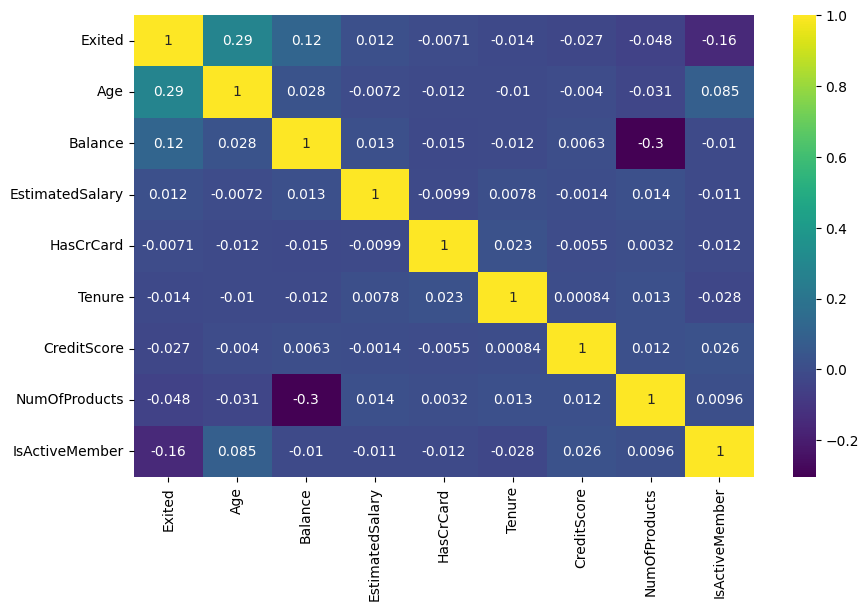

In [ ]:
# Exited correlation matrix
k = 10 #number of variables for heatmap
cols = df.corr().nlargest(k, 'Exited')['Exited'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

# Variance

In [ ]:
# Checking the variance of variables
variance_info = df.var()

print("variance info:")
print(variance_info)

variance info:
CreditScore        9.341860e+03
Age                1.099941e+02
Tenure             8.364673e+00
Balance            3.893436e+09
NumOfProducts      3.383218e-01
HasCrCard          2.077905e-01
IsActiveMember     2.497970e-01
EstimatedSalary    3.307457e+09
Exited             1.622225e-01
dtype: float64


The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


# pandas profiling

In [ ]:
#pandas profiling
profile = df.profile_report(
title = "Pandas Profiling Report",
correlations = {
"pearson": {"calculate": True},
"spearman": {"calculate": True},
"kendall": {"calculate": True}
},
)
#profile.to_file("pandas_profiled.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

No duplicate values in the dataset.
No missing values in the dataset.
From the summary statistics and the graphs, we could conclude that the features looks Ok.
There is much of correlation between any of the variables. The highest correlation is 0.29, which is between Age and Exited, which suggests a small positive relationship between Age and Customer Churn. There could be a relationship between Credit Score, Age, Balance, Number of Products with Exited respectively.

Overall, the correaltion is very weak.

Weak positive correlation with age Very weak positive correlation with balance Very weak negative correlations with number of products and membership

# Onehot encode

In [ ]:
#Onehot encode categorical features
geog = pd.get_dummies(df['Geography'], drop_first=True)
gen = pd.get_dummies(df['Gender'], drop_first=True)


In [ ]:
#Concat the encoded features to the main dataframe
df = pd.concat([df,gen,geog],axis=1)

#Drop the old categorical features
df.drop(['Geography', 'Gender'], axis=1, inplace=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


# scaling

In [ ]:
# features
features = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Exited', 'Male', 'Germany', 'Spain']

In [ ]:
# feature scaling

# normalization dataset with MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
customer_features = df[features]
customer_features

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Germany,Spain
0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0,0.0,0.0,0.0
1,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0,0.0,0.0,1.0
2,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0,0.0,0.0,0.0
3,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0,0.0,0.0,0.0
4,1.000,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.842,0.283784,0.5,0.000000,0.333333,1.0,0.0,0.481341,0.0,1.0,0.0,0.0
9996,0.332,0.229730,1.0,0.228657,0.000000,1.0,1.0,0.508490,0.0,1.0,0.0,0.0
9997,0.718,0.243243,0.7,0.000000,0.000000,0.0,1.0,0.210390,1.0,0.0,0.0,0.0
9998,0.844,0.324324,0.3,0.299226,0.333333,1.0,0.0,0.464429,1.0,1.0,1.0,0.0


In [ ]:
# Standardization
scaler = StandardScaler()
data_stand = scaler.fit_transform(df)

In [ ]:
# Checking mean of each feature
mean_values = data_stand.mean(axis=0)

# Checking standard deviation of each feature
std_dev_values = data_stand.std(axis=0)

# Displaying the mean and standard deviation
print("Mean of each feature after standardization:")
print(mean_values)

print("\nStandard Deviation of each feature after standardization:")
print(std_dev_values)

Mean of each feature after standardization:
[-5.25801624e-17  2.30393482e-16 -9.69890834e-17 -5.68434189e-17
  2.87769808e-17 -5.25801624e-17 -7.38964445e-17  8.06466005e-17
  6.67910172e-17  1.31450406e-16 -7.06990022e-17 -4.68958206e-17]

Standard Deviation of each feature after standardization:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# PCA

In [ ]:
# PCA

pca = PCA(n_components=4)
data_pca = pca.fit_transform(df)


In [ ]:
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

Explained Variance Ratio:
[0.1815528  0.1587977  0.15568359 0.13271483]


In [ ]:
print("Cumulative Explained Variance:")
print(np.cumsum(pca.explained_variance_ratio_))

Cumulative Explained Variance:
[0.1815528  0.3403505  0.49603409 0.62874892]


# Train Test Split

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', axis=1), df['Exited'], test_size=0.2, random_state=42)

# Initializing the XGBoost model
model = XGBRegressor()
# Training the model on the training data
model.fit(X_train, y_train)
# Predicting on the test data
y_pred = model.predict(X_test)
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.11328349743109671


In [ ]:
# Example of hyperparameter optimization for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
# Grid search with cross-validation
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
# Best parameters from grid search
best_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4}  # Replace with your actual best_params

# Initialize XGBoost model with the best parameters
best_model = XGBRegressor(**best_params)

# Train the model on the training data
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred_best = best_model.predict(X_test)

# Evaluate the model
mse_best = mean_squared_error(y_test, y_pred_best)
print(f"Mean Squared Error with Best Parameters: {mse_best}")

Mean Squared Error with Best Parameters: 0.09759047410572504


The model's predictions are close to the actual values, with relatively small errors.

# SHAP values

[07:54:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


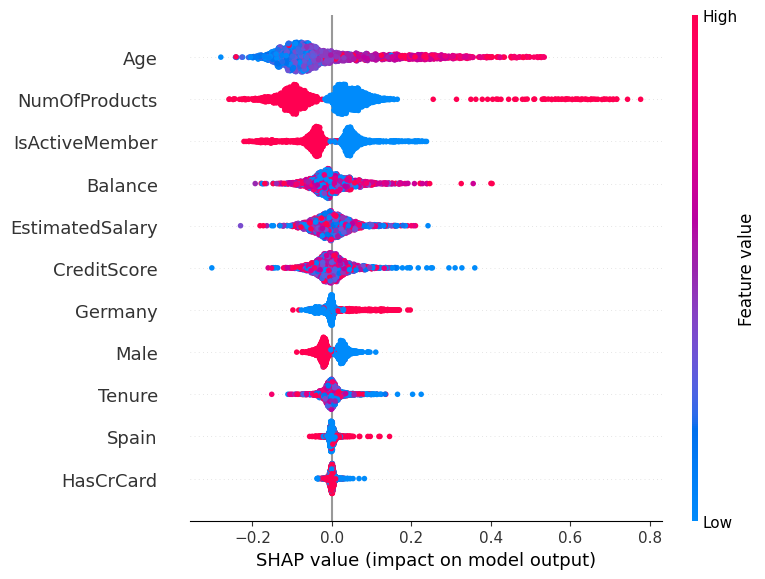

In [ ]:
# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(model)
# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)
# Visualize SHAP values using a summary plot
shap.summary_plot(shap_values, X_test)